Library import

In [53]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Data import

In [54]:
# To read the data into a pandas dataframe:

dataLink = "Data.csv"
rawData = pd.read_csv(dataLink)

rawData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Data Prep #1: Make all columns numeric

In [55]:
# Sex
rawData['Sex']               = np.where((rawData['Sex']=='M'), 1, 0) #1 is male, 0 is female

# Chest pain
rawData['ChestPainType_ATA'] = np.where((rawData['ChestPainType']=='ATA'), 1, 0)
rawData['ChestPainType_NAP'] = np.where((rawData['ChestPainType']=='NAP'), 1, 0)

# RestingECG
rawData['RestingECG_Normal'] = np.where((rawData['RestingECG']=='Normal'), 1, 0)
rawData['RestingECG_ST']     = np.where((rawData['RestingECG']=='ST'), 1, 0)
rawData['RestingECG_LVH']    = np.where((rawData['RestingECG']=='LVH'), 1, 0)

# ExerciseAngina
rawData['ExerciseAngina_N']  = np.where((rawData['ExerciseAngina']=='N'), 1, 0)
rawData['ExerciseAngina_Y']  = np.where((rawData['ExerciseAngina']=='Y'), 1, 0)

# ST_Slope  
rawData['ST_Slope_Down']     = np.where((rawData['ST_Slope']=='Down'), 1, 0)
rawData['ST_Slope_Flat']     = np.where((rawData['ST_Slope']=='Flat'), 1, 0)
rawData['ST_Slope_Up']       = np.where((rawData['ST_Slope']=='Up'), 1, 0)

# Dropping the old columns
rawData = rawData.drop(['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)

rawData.head()


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,RestingECG_Normal,RestingECG_ST,RestingECG_LVH,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0.0,0,1,0,1,0,0,1,0,0,0,1
1,49,0,160,180,0,156,1.0,1,0,1,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0.0,0,1,0,0,1,0,1,0,0,0,1
3,48,0,138,214,0,108,1.5,1,0,0,1,0,0,0,1,0,1,0
4,54,1,150,195,0,122,0.0,0,0,1,1,0,0,1,0,0,0,1


Data prep #2: Check outliers

In [56]:
# Let's investigate the outliers using Cook's D

#First create the model
model = sm.ols('HeartDisease ~ Age+Sex+RestingBP+Cholesterol+FastingBS+MaxHR+Oldpeak+ChestPainType_ATA+ChestPainType_NAP+RestingECG_Normal+RestingECG_ST+RestingECG_LVH+ExerciseAngina_N+ExerciseAngina_Y++ST_Slope_Down+ST_Slope_Flat+ST_Slope_Up', data = rawData).fit()


cooksD = model.get_influence().cooks_distance #Calculate Cook's D values from model 1
n = len(rawData) # Calculate the size of the sample
rawData['Outlier'] = cooksD[0] > 4/n 

DF_outlier_Data = rawData[rawData.Outlier == True]
DF_remove_Outliers = rawData[rawData.Outlier == False]
DF_outlier_Data.count() #38 outliers, according to cook's D in this data set

# Let's create 2 models, (1) one with all the outliers, (2) one with all outliers removed:
model1 = sm.ols('HeartDisease ~ Age+Sex+RestingBP+Cholesterol+FastingBS+MaxHR+Oldpeak+ChestPainType_ATA+ChestPainType_NAP+RestingECG_Normal+RestingECG_ST+RestingECG_LVH+ExerciseAngina_N+ExerciseAngina_Y++ST_Slope_Down+ST_Slope_Flat+ST_Slope_Up', data = rawData).fit()
model2 = sm.ols('HeartDisease ~ Age+Sex+RestingBP+Cholesterol+FastingBS+MaxHR+Oldpeak+ChestPainType_ATA+ChestPainType_NAP+RestingECG_Normal+RestingECG_ST+RestingECG_LVH+ExerciseAngina_N+ExerciseAngina_Y++ST_Slope_Down+ST_Slope_Flat+ST_Slope_Up', data = DF_remove_Outliers).fit()

print(model1.summary())
print(model2.summary())

#Removing all outliers does changes the outcome of the model, 
# for example R-Squared goes from 0.554 in model1 to 0.651 in model2, the P values remain mostly the same so model 2 will be used.

                            OLS Regression Results                            
Dep. Variable:           HeartDisease   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     85.29
Date:                Fri, 02 Jun 2023   Prob (F-statistic):          2.57e-154
Time:                        11:18:16   Log-Likelihood:                -274.27
No. Observations:                 918   AIC:                             578.5
Df Residuals:                     903   BIC:                             650.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2562      0.06

Final Data Prep: Check correlations

<AxesSubplot: >

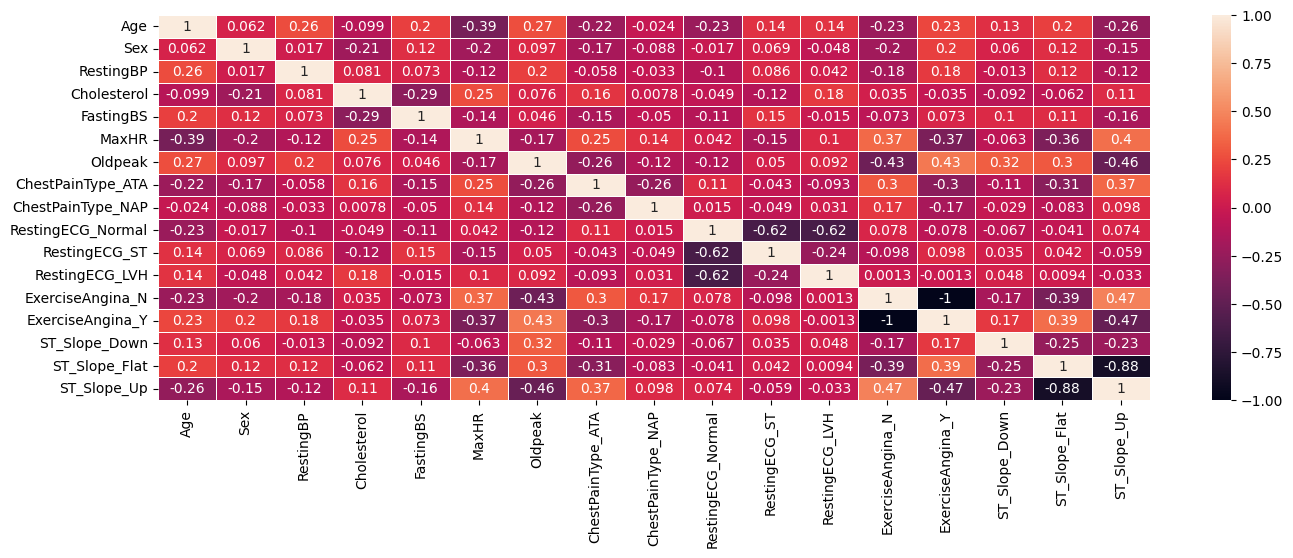

In [57]:
# Let's create a matrix to show the correlations between values
correlationMatrix = DF_remove_Outliers[['Age','Sex','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','ChestPainType_ATA','ChestPainType_NAP','RestingECG_Normal','RestingECG_ST','RestingECG_LVH','ExerciseAngina_N','ExerciseAngina_Y','ST_Slope_Down','ST_Slope_Flat','ST_Slope_Up']].corr()

plt.figure(figsize = (16,5))
sns.heatmap(correlationMatrix, annot=True, linewidths=.6)

# As seen in the matrix below, there is no strong correlation between any columns. The highest is 0.46

Data splitting: Creating test and training data

In [58]:
# As far as the dataset goes, there are no columns that can not be used for predicting heart disease in other words: 
# Nothing has to be eliminated from the dataset.
prepData = DF_remove_Outliers
prepData.head()

#The column 'Outcome' is what we want to predict, 1 is tested and diagnosed with Diabetes and 0 is tested but not diagnosed with diabetes.
cntOutcome = prepData['HeartDisease'].value_counts()
propOutcome = prepData['HeartDisease'].value_counts(normalize=True)

#Amount of Outcomes
cntOutcome

#Normalized amount of Outcomes
propOutcome

#Transform the column 'Outcome' to the type Category instead of integer. 
#This is necessary since most models in general cannot use an Integer as a category, they require a column of the type 'Category
catType = pd.CategoricalDtype(categories=[0, 1], ordered=False)
prepData['HeartDisease'] = prepData['HeartDisease'].astype(catType)
prepData['HeartDisease']

#To see if it worked, uncomment the follow line of code (22):
# prepData.info()

#The data set contains 7 fields on which the outcome can be based. The following line of code allows us to take a more detailed look into the data:
#prepData[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction', 'Age']].describe()

#To have a more realistic and clear view the data, we will normalize it so we can make better comparisons for each column


excluded = ['HeartDisease', 'Outlier'] #This column will be excluded
X = prepData.loc[:, ~prepData.columns.isin(excluded)] #This will fetch the data minus the excluded column and put it into the variable X

scaler = MinMaxScaler()

data = scaler.fit_transform(X)
X[['Age','Sex','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','ChestPainType_ATA','ChestPainType_NAP','RestingECG_Normal','RestingECG_ST','RestingECG_LVH','ExerciseAngina_N','ExerciseAngina_Y','ST_Slope_Down','ST_Slope_Flat','ST_Slope_Up']].describe() #This is the same as earlier code but now normalized

labels = prepData['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=123)


##################################
#DATA PREPARATION IS NOW COMPLETE#
##################################

C:\Users\robin\AppData\Local\Temp\ipykernel_18408\2269590969.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepData['HeartDisease'] = prepData['HeartDisease'].astype(catType)


Modelling and evaluation

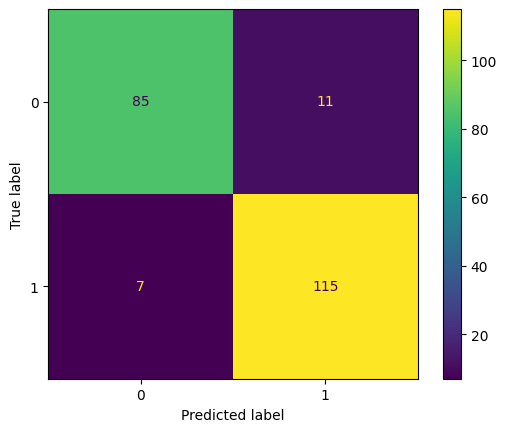

Accuracy of the model is 0.9174311926605505


In [59]:

#Model in python code:
knn = KNeighborsClassifier(n_neighbors=5) 
#This means that it will classify the data using it's 10 nearest neighbours. 
#So in other words: I have 10 neighbours with similar data, what is their classification? If most or all, for example, are category 1, it will apply category 1.

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
cm

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

acc = accuracy_score(y_test, y_pred)
print("Accuracy of the model is", acc)
